In [1]:
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from util.TrainRoutine import AutoEncTrainRoutine
from util.Evaluator import Evaluator
from util.aedpmerf import AEDPMERF

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We want to use the DPMERF algorithm on time series data. But we will not work on time series directly, because it does not model the temporal relation correctly. Instead we will train an AE first and use DPMERF on the encoding space, where there is no notion of time and ordering.

In [2]:
emd_dim = 32
ae_gen = AutoEncTrainRoutine(emb_dim=emd_dim)

------------------------------
Initialising Autoencoder with:
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on cuda
------------------------------


loss: 72.688217  [    1/69828]
loss: 11.147552  [10001/69828]
loss: 2.033819  [20001/69828]
loss: 5.443711  [30001/69828]
loss: 1.639742  [40001/69828]
loss: 3.207141  [50001/69828]
loss: 2.471016  [60001/69828]
Epoch 1: train loss = 4.869504055486837, val loss = 3.6015200391138866
loss: 3.825171  [    1/69828]
loss: 2.132829  [10001/69828]
loss: 2.437496  [20001/69828]
loss: 4.356341  [30001/69828]
loss: 3.779201  [40001/69828]
loss: 2.142952  [50001/69828]
loss: 2.657430  [60001/69828]
Epoch 2: train loss = 3.2383683049600953, val loss = 3.09897954138644
loss: 1.902760  [    1/69828]
loss: 5.383269  [10001/69828]
loss: 5.228620  [20001/69828]
loss: 1.414504  [30001/69828]
loss: 1.773846  [40001/69828]
loss: 2.895136  [50001/69828]
loss: 2.461575  [60001/69828]
Epoch 3: train loss = 2.675909758543698, val loss = 2.593475834968908
loss: 2.088724  [    1/69828]
loss: 1.576003  [10001/69828]
loss: 2.803488  [20001/69828]
loss: 2.396385  [30001/69828]
loss: 1.497963  [40001/69828]
loss: 2

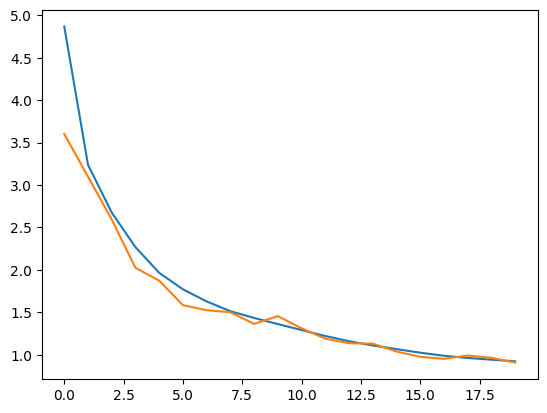

In [3]:
model_name = f"lstmae_180_embed{emd_dim}.pth"
if os.path.exists(f"models/{model_name}"):
    ae_gen.load_model(model_name)
else:
    model, history = ae_gen.train_model(train_ds_path="data/normal_train_180.csv", val_ds_path="data/normal_val_180.csv")
    plt.plot(history["train"])
    plt.plot(history["val"])
    ae_gen.save_model(model_name)

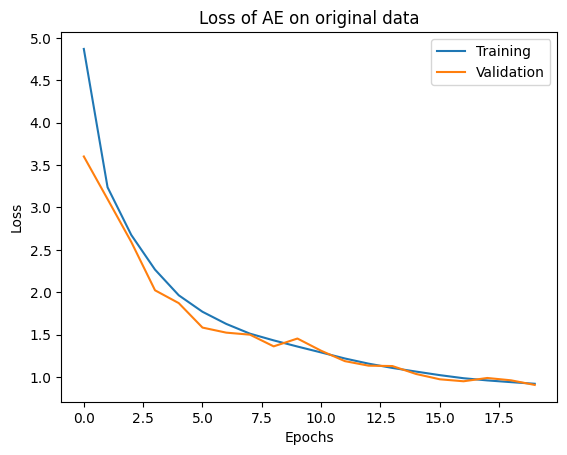

In [10]:
plt.plot(history["train"])
plt.plot(history["val"])
plt.title("Loss of AE on original data")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [11]:
window_size=180
evaluator = Evaluator(val_normal_path=f"data/normal_val_{window_size}.csv",
                      val_anomaly_path=f"data/anomaly_val_{window_size}.csv",
                        test_normal_path=f"data/normal_test{window_size}.csv",
                        test_anomaly_path=f"data/anomalie_test{window_size}.csv", 
                        model=ae_gen.model)

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([180, 1])) that is different to the input size (torch.Size([1, 180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


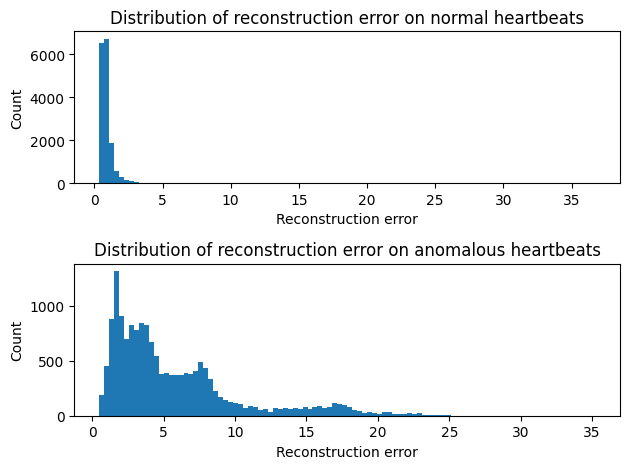

In [12]:
plt.figure()

plt.subplot(2,1,1)
plt.hist(evaluator.loss_val_normal, bins=100)
plt.xlabel("Reconstruction error")
plt.ylabel("Count")
plt.title("Distribution of reconstruction error on normal heartbeats")

plt.subplot(2,1,2)
plt.hist(evaluator.loss_val_anomaly, bins=100)
plt.xlabel("Reconstruction error")
plt.ylabel("Count")
plt.title("Distribution of reconstruction error on anomalous heartbeats")
plt.tight_layout()
plt.show()

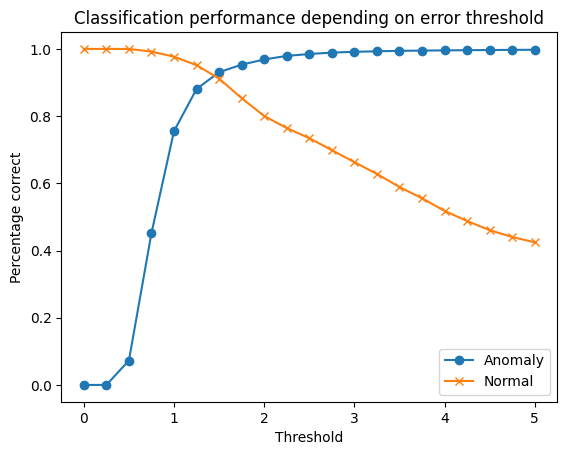

In [13]:
corr_normal, corr_anomaly = evaluator.find_threshold()
plt.plot(np.linspace(0,5,21), corr_normal, marker="o")
plt.plot(np.linspace(0,5,21), corr_anomaly, marker="x")
plt.xlabel("Threshold")
plt.ylabel("Percentage correct")
plt.legend(["Anomaly", "Normal"])
plt.title("Classification performance depending on error threshold")
plt.show()

In [14]:
predictions_normal, predictions_anomaly = evaluator.predict_class(1.5)


In [15]:
evaluator.evaluate(predictions_normal, predictions_anomaly)

TP: 1651
FN: 109
FP: 165
TN: 1639
Acc: 0.9231200897867564
Precision: 0.9091409691629956
Recall: 0.9380681818181819
F1: 0.9233780760626399
